Problem Set 5: A* search on Euclidean spaces
========================

In this problem, we’re going to examine the results of using A ∗ with
different potential functions.


In [1]:
# You may need to `pip install networkx` and `pip install numpy`
# We'll use NetworkX as in problem set 3.
import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html

import numpy
import heapq

#Visualization tools
import pylab
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10)


# Graph generation and visualization

In [2]:
def generate_graph(n, d):
    """Generate a random Euclidean graph.
    
    n points are placed uniformly on [-1, 1]^2 and bidirectionally
    connected to the nearest d other points.  The distance is the
    Euclidean distance between the points.
    """
    
    # Compute the positions of the n points
    locs = numpy.random.rand(n, 2)
    # Compute the pairwise difference vectors (for an n x n x 2 matrix)
    gaps = locs.reshape(n, 1, 2) - locs.reshape(1, n, 2)
    # Compute the pairwise differences
    distances = numpy.linalg.norm(gaps, axis=2)
    nearest = numpy.argpartition(distances, d)[:,:d]
    ## Convert into a list of pairs
    #edge_list = [(i, j) for i, lst in enumerate(nearest) for j in lst if i != j]

    # Now make a NetworkX graph
    G = nx.DiGraph()
    for i, (x,y) in enumerate(locs):
        G.add_node(i, point=(x, y))
    for i, lst in enumerate(nearest):
        for j in lst:
            G.add_edge(i, j, weight=distances[i][j])
            if i not in nearest[j]: # Make sure it's symmetric
                G.add_edge(j, i, weight=distances[i][j])
    return G

In [3]:
def draw_graph(G, **kws):
    default_kws = dict(node_size=3.5, linewidths=0, width=0.05,
                       with_labels=False, alpha=1, arrows=False)
    default_kws.update(kws)
    nx.draw_networkx(G, {k:v['point'] for k,v in G.node.items()},
                     **default_kws)
    pylab.xlim([0,1])
    pylab.ylim([0,1])

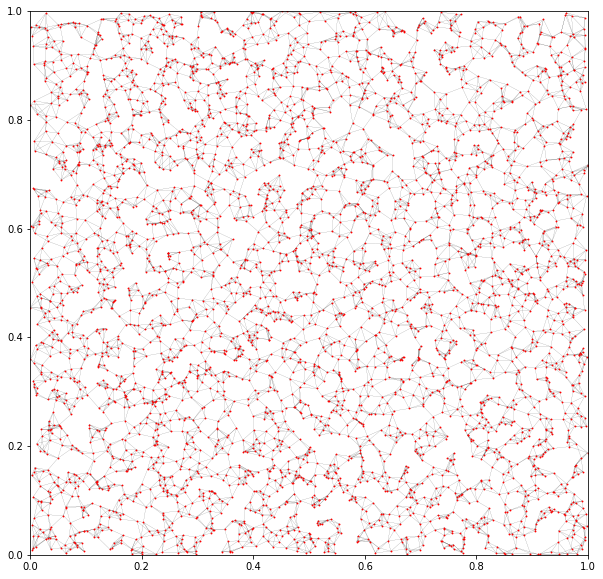

In [4]:
# Example
G = generate_graph(4000, 6)
draw_graph(G)

# Shortest path computation

In [5]:
def dijkstra(G, s, t, potential = lambda u: 0):
    """Find the shortest path from s to t using Dijkstra/A*.

    Given:
      - s, the node to start from
      - t, the node to finish at (or None)
      - potential, a function from node id to R.

    Returns a tuple containing:
       - path, a list containing nodes along the shortest path from s to t.
       - visited, the set of nodes that were visited by the time t was reached.
       - prev, a dict giving back pointers on the shortest path
         tree starting at s.  prev[v] is correct for all v in visited.
       - dists, a dict giving the distance to nodes.  This should be
         correct for visited nodes.

    If t is None, it returns the full shortest path tree from s, and
    'path' is None.
    """
    dists = {}
    visited = set()
    dists[s] = 0
    heap = []
    heapq.heappush(heap, (dists[s] + potential(s), s))
    prev = {}
    while heap and t not in visited:
        _, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        for v in G[u]:
            length = G[u][v]['weight']
            # Relax/tighten an edge.
            if dists[u] + length < dists.get(v, 1e9):
                dists[v] = dists[u] + length
                prev[v] = u
                heapq.heappush(heap, (dists[v] + potential(v), v))
    # Now find the path, if we have a destination.
    if t is None:
        path = None
    else: # Find the s-t path.
        if t not in prev:
            print('Warning: no path from s to t')
            path = []
        else:
            v = t
            path = [v]
            while v != s:
                v = prev[v]
                path.append(v)
            path.reverse()
    return (path, visited, prev, dists)

In [6]:
# We need to be able to visualize the result
def visualize_path(G, s, t, path, visited, prev, dists=None, **kws):
    print("Got s-t distance", dists.get(t), 'visiting', len(visited), 'nodes')
    # Full graph
    draw_graph(G, width=0.03)
    # Visited nodes
    draw_graph(G,  width=0, nodelist=visited,
               edgelist=[e for e in G.edges() if e[0] in visited], 
               node_size=4, node_color='green')
    # Computed shortest path tree
    draw_graph(G,  width=0.3, nodelist=[],
               edgelist=[e for e in G.edges() if prev.get(e[1]) == e[0] ], 
               node_size=4, node_color='green')
    # Computed shortest s-t path tree
    if path:
        pathset = set(path)
        draw_graph(G,  width=1, nodelist=[],
                   edgelist=[e for e in G.edges() if prev.get(e[1]) == e[0] 
                            and e[1] in pathset], 
                   node_size=4, node_color='green')
    # s and t
    draw_graph(G, nodelist=[s], edgelist=[],
               node_size=40, node_color='purple')
    if t is not None:
        draw_graph(G, nodelist=[t], edgelist=[],
                   node_size=40, node_color='blue')


Got s-t distance 0.478506394438 visiting 801 nodes


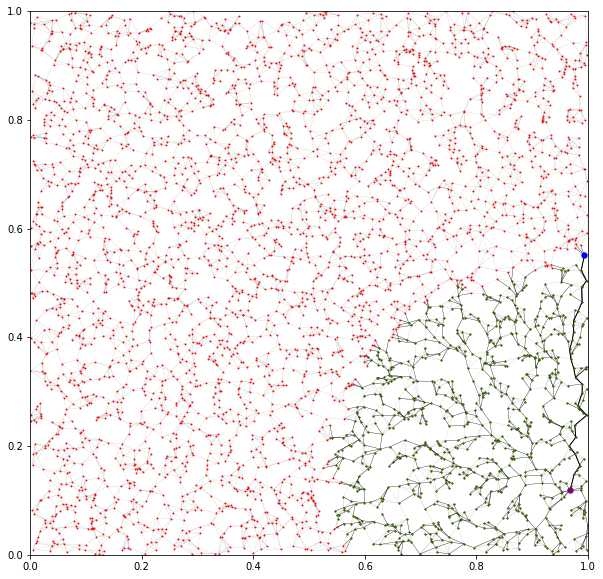

In [7]:
# Example usage
# purple dot = source, blue dot = sink, green = visited, red = unvisited
# Thickest lines = shortest s-t path
# medium thick lines = edges on shortest path tree

G = generate_graph(4000, 6)
s, t = 0, 1
visualize_path(G, s, t, *dijkstra(G, s, t))

# Run this several times to see how it behaves.

In [8]:
#Now let's try a couple heuristics

def euclidean(a, b):
    """Return the Euclidean (ell_2) distance between two vectors."""
    return sum((x - y)**2 for x, y in zip(a, b))**.5

def manhattan(a, b):
    """Return the Manhattan (ell_1) distance between two vectors."""
    return sum(abs(x - y) for x, y in zip(a, b))

Got s-t distance 0.97827283222 visiting 3136 nodes
Got s-t distance 0.97827283222 visiting 565 nodes
Got s-t distance 1.0063204303 visiting 61 nodes


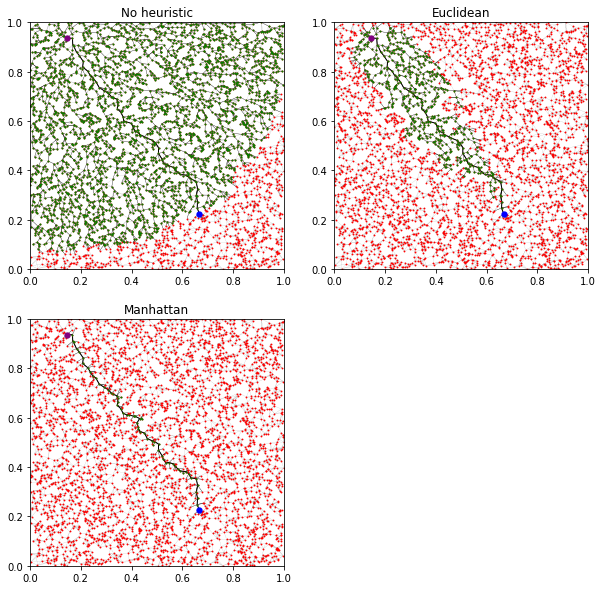

In [9]:
G = generate_graph(4000, 6)
s, t = 0, 1
pylab.subplot(2,2,1)
visualize_path(G, s, t, *dijkstra(G, s, t))
pylab.title("No heuristic")
pylab.subplot(2,2,2)
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: euclidean(G.node[u]['point'], G.node[t]['point'])))
pylab.title("Euclidean")
pylab.subplot(2,2,3)
visualize_path(G, s, t, *dijkstra(G, s, t,
        lambda u: manhattan(G.node[u]['point'], G.node[t]['point'])))
pylab.title("Manhattan")

#Run this a few times.

Problem 1
----------

When you run the above code, sometimes one of the distances will not match the other two.  Why is that?

Problem 2
----------

Implement the ALT heuristic.  The ALT stands
for "A^∗, landmarks, and triangle inequality". It’s a way of preprocessing the graph to construct a potential function such that
fresh queries--new s and t pairs--can be solved very efficiently.

This is useful for something like Google Maps, where they get many many queries on the same graph, and need to respond very quickly to each one.  So it makes sense to spend some preprocessing time beforehand to make the queries fast.

The idea behind ALT is to choose a small number nodes `l_1, ..., l_L` to be "landmarks" (say, 10-20). We preprocess the graph using full Dijkstra
to compute `dist(u, l_i)` for all vertices `u` and landmarks `l_i`.
On a new query s, t, we observe by the triangle inequality that
```
dist(u, t) ≥ dist(u, l) − dist(t, l)
```
and
```
dist(u, t) ≥ dist(l, t) − dist(l i , u)
```
for all landmarks `l`. Hence, if we set
```
potential(u) := max |dist(u, l) − dist(t, l)|
```
we get an admissible heuristic (i.e., `potential(u) ≤ d(u, t)` for all `u`).

 Part (a). show that this potential function is in fact consistent.  I.e., 
```
potential(u) - potential(v) <= dist(u, v)
```
 for all `u, v`.

TypeError: unsupported operand type(s) for +: 'int' and 'ellipsis'

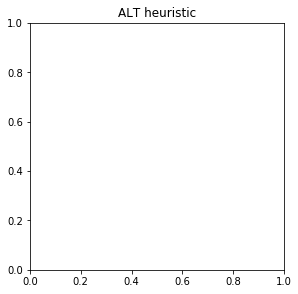

In [10]:
# Part 2.(b)  Implement the ALT heuristic.

# With 20 landmarks, it should usually visit less than 1/3 as many
# nodes as the Euclidean heuristic. (You can either choose random
# landmarks or try to pick them more carefully.)

def create_landmark_heuristic_generator(G):
    """Preprocess the graph so that one can compute a heuristic
    for any desired destination t.
    
    Returns a function that takes t and returns a heuristic
    targetted at t.
    """
    # Construct landmarks and distances to/from landmarks
    ... # do preprocessing
    # 
    def construct_heuristic_for(t):
        def heuristic(u):
            return ... #estimate of u->t distance
        return heuristic
    return construct_heuristic_for


# Now you should be able to plot it with something like this.
pylab.subplot(2,2,4)
pylab.title("ALT heuristic")
heuristic_generator = create_landmark_heuristic_generator(G)

heuristic_for_t = heuristic_generator(t)
visualize_path(G, s, t, *dijkstra(G, s, t, heuristic_for_t))


# Try to make sure it's plotted on the same graph as the other
# heuristics above.  How does the number of visited nodes
# compare?

Problem 3
---------

So far we've compared the number of visited nodes among the different algorithms.  How do their running time compare for this `n` and `d`?  How does it change with `n` and `d`?  Try to get fairly accurate time estimates.

Problem 4
---------

Implement Prim's algorithm and visualize it for this graph.